In [1]:
import pyedflib
import numpy as np
import os
import connectivipy as cp
from connectivipy import mvar_gen
import networkx as nx 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
current_dir = os.getcwd()
print(current_dir)
subject = "S079"
sub_edf = "S079R01.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#eo stands for eyes open, it is the numpy array corresponding to the first run
eo = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    eo[i, :] = f.readSignal(i)
f.close()
eo

/home/giulia/corsi/bio/project/BigBrain


array([[117., 149., 118., ...,   0.,   0.,   0.],
       [146., 161., 156., ...,   0.,   0.,   0.],
       [111., 131., 135., ...,   0.,   0.,   0.],
       ...,
       [ 17.,  28.,  40., ...,   0.,   0.,   0.],
       [ 22.,  28.,  30., ...,   0.,   0.,   0.],
       [ 45.,  62.,  61., ...,   0.,   0.,   0.]])

In [3]:
print("\nlibrary version: %s" % pyedflib.version.version)
print("\ngeneral header:\n")
print("edfsignals: %i" % f.signals_in_file)
print("file duration: %i seconds" % f.file_duration)
print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
print("patientcode: %s" % f.getPatientCode())
print("gender: %s" % f.getGender())
print("birthdate: %s" % f.getBirthdate())
print("patient_name: %s" % f.getPatientName())
print("patient_additional: %s" % f.getPatientAdditional())
print("admincode: %s" % f.getAdmincode())
print("technician: %s" % f.getTechnician())
print("equipment: %s" % f.getEquipment())
print("recording_additional: %s" % f.getRecordingAdditional())
print("datarecord duration: %f seconds" % f.getFileDuration())
print("number of datarecords in the file: %i" % f.datarecords_in_file)
print("number of annotations in the file: %i" % f.annotations_in_file)


library version: 0.1.15

general header:

edfsignals: 64
file duration: 61 seconds
startdate: 12-8-2009
starttime: 16:15:00
patientcode: 
gender: 
birthdate: 
patient_name: X
patient_additional: 
admincode: 
technician: 
equipment: BCI2000
recording_additional: 
datarecord duration: 61.000000 seconds
number of datarecords in the file: 61
number of annotations in the file: 1


In [35]:
#fitting in the model for eo with method yule-walker
model_eo = cp.Mvar().fit(eo, method = "yw")

eo_pdc=cp.conn.pdc_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

density=0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

eo_adj = (eo_pdc > threshold).astype(int)

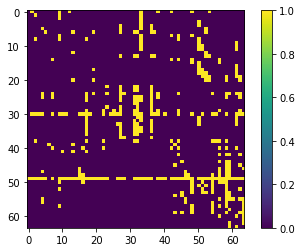

In [36]:
plt.imshow(eo_adj);
plt.colorbar()
plt.savefig("binary_matrix_OPEN.png", format="PNG")
plt.show()

###### 1.1 
Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

{0: 'Fc5.', 1: 'Fc3.', 2: 'Fc1.', 3: 'Fcz.', 4: 'Fc2.', 5: 'Fc4.', 6: 'Fc6.', 7: 'C5..', 8: 'C3..', 9: 'C1..', 10: 'Cz..', 11: 'C2..', 12: 'C4..', 13: 'C6..', 14: 'Cp5.', 15: 'Cp3.', 16: 'Cp1.', 17: 'Cpz.', 18: 'Cp2.', 19: 'Cp4.', 20: 'Cp6.', 21: 'Fp1.', 22: 'Fpz.', 23: 'Fp2.', 24: 'Af7.', 25: 'Af3.', 26: 'Afz.', 27: 'Af4.', 28: 'Af8.', 29: 'F7..', 30: 'F5..', 31: 'F3..', 32: 'F1..', 33: 'Fz..', 34: 'F2..', 35: 'F4..', 36: 'F6..', 37: 'F8..', 38: 'Ft7.', 39: 'Ft8.', 40: 'T7..', 41: 'T8..', 42: 'T9..', 43: 'T10.', 44: 'Tp7.', 45: 'Tp8.', 46: 'P7..', 47: 'P5..', 48: 'P3..', 49: 'P1..', 50: 'Pz..', 51: 'P2..', 52: 'P4..', 53: 'P6..', 54: 'P8..', 55: 'Po7.', 56: 'Po3.', 57: 'Poz.', 58: 'Po4.', 59: 'Po8.', 60: 'O1..', 61: 'Oz..', 62: 'O2..', 63: 'Iz..'}


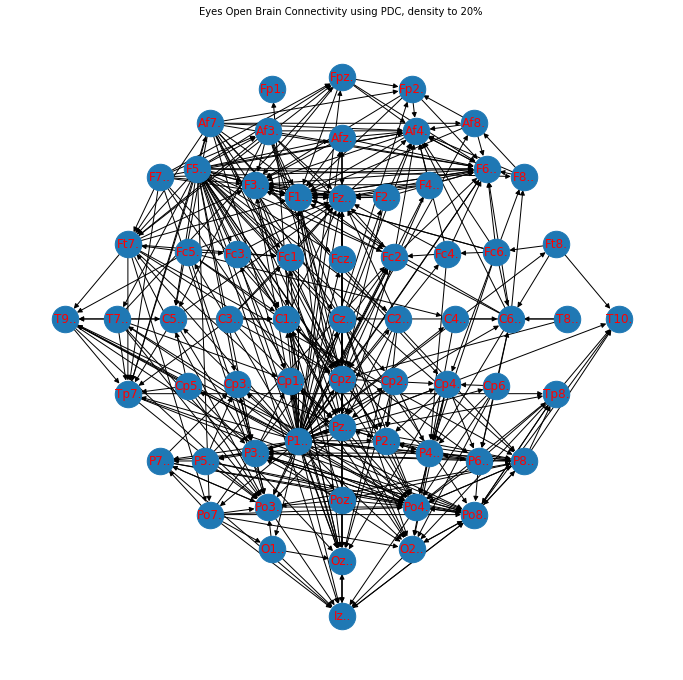

In [37]:
position=pd.read_csv('channel_locations.txt', sep='\s+')

G_open = nx.DiGraph(eo_adj)
#rename labels
labels={}
for i in range(0, 64):
    labels[i]=position['label'][i]
print(labels)
G_open= nx.relabel_nodes(G_open,labels) 
#create a pos dictionary to pass the position to the nodes of our graph
pos={}
for i in range(0, 64):
    pos[position['label'][i]]=[position['x'][i],position['y'][i]]

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Eyes Open Brain Connectivity using PDC, density to 20% ', fontsize=10)

nx.draw(G_open, pos, node_size=700)
nx.draw_networkx_labels(G_open, pos=pos, font_color='red')
#nx.draw(G_open, with_labels=True)

plt.savefig("PDC_eyes_open.png", format="PNG")
plt.show()

In [38]:
current_dir = os.getcwd()
print(current_dir)
subject = "S079"
sub_edf = "S079R02.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#ec stands for eyes closed, it is the numpy array corresponding to the second run
ec = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    ec[i, :] = f.readSignal(i)


#fitting in the model for ec with method yule-walker
model_ec = cp.Mvar().fit(ec, method = "yw")

#compute PDC
ec_pdc=cp.conn.pdc_fun(model_ec[0],model_ec[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = ec_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_pdc > threshold).astype(int)

/home/giulia/corsi/bio/project/BigBrain


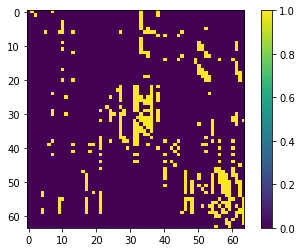

In [39]:
plt.imshow(ec_adj);
plt.colorbar()
plt.savefig("binary_matrix_CLOSE.png", format="PNG")
plt.show()

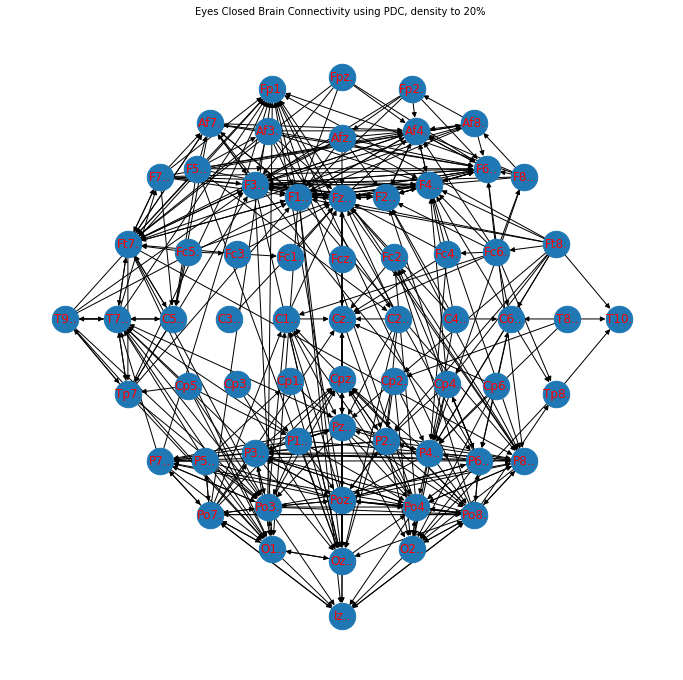

In [40]:
position = pd.read_csv('channel_locations.txt', sep='\s+')

G_close = nx.DiGraph(ec_adj)
#rename labels

G_close = nx.relabel_nodes(G_close,labels) 
#create a pos dictionary to pass the position to the nodes of our graph

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Eyes Closed Brain Connectivity using PDC, density to 20% ', fontsize=10)

nx.draw(G_close, pos, node_size=700)
nx.draw_networkx_labels(G_close, pos=pos, font_color='red')
#nx.draw(G_open, with_labels=True)

plt.savefig("PDC_eyes_closed.png", format="PNG")
plt.show()

(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also the file channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density≤5%).

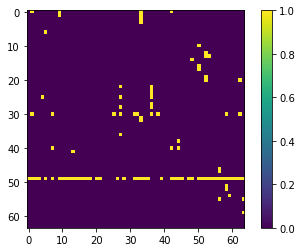

In [10]:
density = 0.05 #set the density to 0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

#adj_matrix
eo_adj_low = (eo_pdc > threshold).astype(int)

plt.imshow(eo_adj_low);
plt.colorbar()
plt.show()

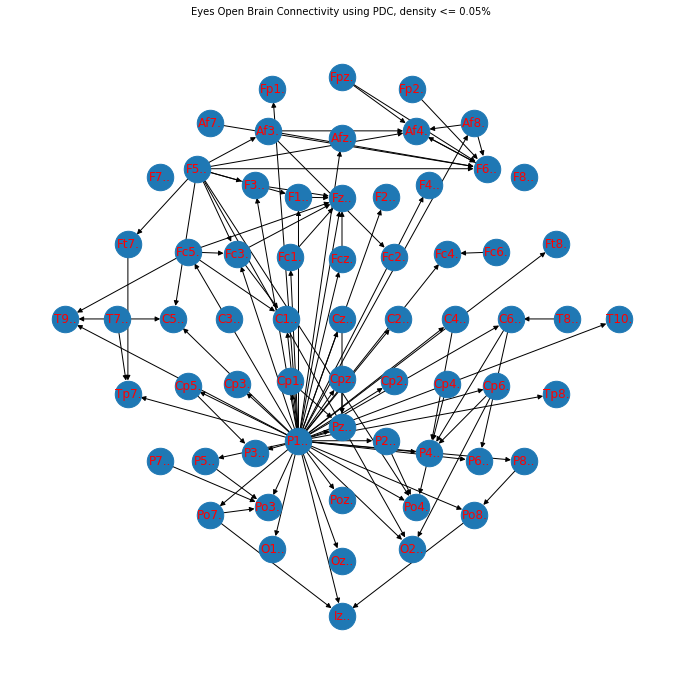

In [11]:
G_open_low = nx.DiGraph(eo_adj_low)
#rename labels

G_open_low= nx.relabel_nodes(G_open_low,labels) 
#create a pos dictionary to pass the position to the nodes of our graph

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Eyes Open Brain Connectivity using PDC, density <= 0.05% ', fontsize=10)

nx.draw(G_open_low, pos, node_size=700)
nx.draw_networkx_labels(G_open_low, pos=pos, font_color='red')

plt.savefig("PDC_eyes_open_lowdensity.png", format="PNG")
plt.show()

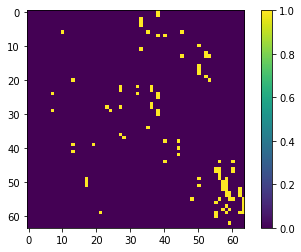

In [12]:
density = 0.05 #set the density to 0.2
n = ec_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj_low = (ec_pdc > threshold).astype(int)

plt.imshow(ec_adj_low);
plt.colorbar()
plt.show()

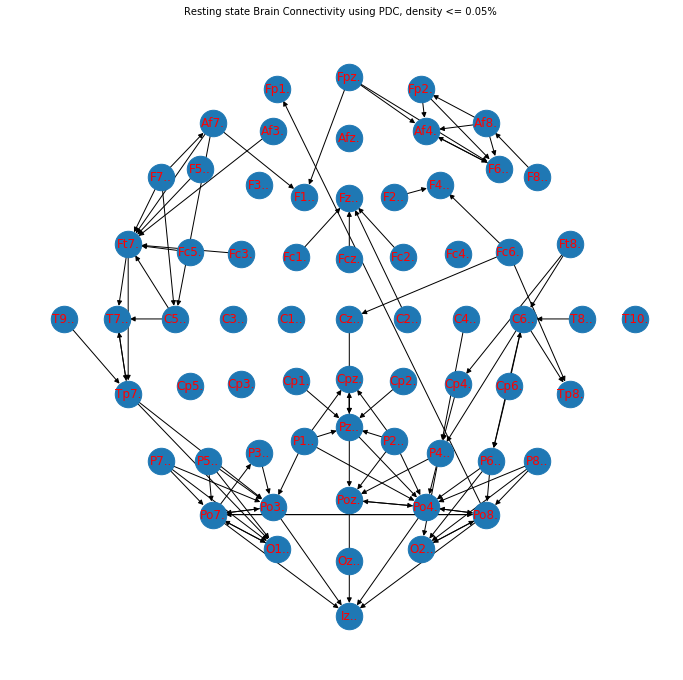

In [13]:
G_close_low = nx.DiGraph(ec_adj_low)
#rename labels

G_close_low= nx.relabel_nodes(G_close_low,labels) 
#create a pos dictionary to pass the position to the nodes of our graph

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Resting state Brain Connectivity using PDC, density <= 0.05% ', fontsize=10)

nx.draw(G_close_low, pos, node_size=700)
nx.draw_networkx_labels(G_close_low, pos=pos, font_color='red')

plt.savefig("PDC_eyes_closed_lowdensity.png", format="PNG")
plt.show()

2.1. COMPUTE BINARY GLOBAL (CLUSTERING COEFFICIENT, PATH LENGHT) AND LOCAL (DEGREE, IN/OUT-DEGREE) GRAPH INDICES.
LIST THE HIGHEST 10 CHANNELS FOR LOCAL INDICES.

In [14]:
def return_globals(graph):
    return nx.average_clustering(graph), nx.average_shortest_path_length(graph)

In [15]:
#LOCAL IN-DEGREE for G_OPEN
def f_node_in_degree(graph):
    node_in_degree = {}
    #LOCAL IN-DEGREE for G_OPEN
    count_iter = 0
    for n in graph:
        node_in_degree[position['label'][count_iter]]=[graph.in_degree(n)]
        count_iter += 1
    return node_in_degree

def f_node_out_degree(graph):
    #LOCAL OUT-DEGREE for G_OPEN
    node_out_degree = {}
    count_iter = 0
    for n in graph:
        node_out_degree[position['label'][count_iter]]=[graph.out_degree(n)]
        count_iter += 1
    return node_out_degree


def f_node_degree(graph):
    #LOCAL DEGREE for G_OPEN
    node_degree = {}
    count_iter = 0  
    for n in graph:
        node_degree[position['label'][count_iter]]=[graph.degree(n)]
        count_iter += 1
    return node_degree

In [16]:
#list the top 10 channels with highest degree
def return_n_highest_from_dict(my_dict, n):
    highest = sorted(my_dict, key=my_dict.get, reverse=True)[:n]
    return highest


def return_indices(graph):
    #global clustering coefficient
    open_avgc, open_avspl = return_globals(graph)
    print("Average clustering for graph:", open_avgc, 
          "\nAverage shortest path lenght for graph: ", open_avspl)
    node_in_degree = f_node_in_degree(graph)
    node_out_degree = f_node_out_degree(graph)
    node_degree = f_node_degree(graph)
    print("Top 10 highest degree channel for graph")
    highest = return_n_highest_from_dict(node_degree, 10)
    print(highest, "\n")
    print("Top 10 highest in-degree channel graph")
    highest = return_n_highest_from_dict(node_in_degree, 10)
    print(highest, "\n")
    print("Top 10 highest out-degree channel for graph")
    highest = return_n_highest_from_dict(node_out_degree, 10)
    print(highest, "\n")

In [18]:
return_indices(G_open)
return_indices(G_close)

Average clustering for graph: 0.2916532140923494 
Average shortest path lenght for graph:  1.2098214285714286
Top 10 highest degree channel for graph
['P1..', 'F5..', 'Fz..', 'Po4.', 'F1..', 'F6..', 'Pz..', 'Af4.', 'F3..', 'P3..'] 

Top 10 highest in-degree channel graph
['Po4.', 'Fz..', 'F6..', 'Af4.', 'F1..', 'F3..', 'Oz..', 'Cpz.', 'Pz..', 'Po3.'] 

Top 10 highest out-degree channel for graph
['P1..', 'F5..', 'Af7.', 'Af3.', 'F7..', 'Ft7.', 'Fc6.', 'Fc5.', 'Fz..', 'T7..'] 

Average clustering for graph: 0.3310676304882518 
Average shortest path lenght for graph:  1.7589285714285714
Top 10 highest degree channel for graph
['F1..', 'F3..', 'Fz..', 'Po8.', 'Ft7.', 'Po3.', 'Poz.', 'Po4.', 'F4..', 'F6..'] 

Top 10 highest in-degree channel graph
['F3..', 'F1..', 'Fz..', 'Oz..', 'Fp1.', 'F6..', 'P8..', 'Af4.', 'F4..', 'Po3.'] 

Top 10 highest out-degree channel for graph
['Po8.', 'F1..', 'Poz.', 'Ft7.', 'Ft8.', 'P2..', 'P6..', 'Po7.', 'Po3.', 'Po4.'] 



(class ‘D’) Search in the literature a definition of small-worldness index (i.e. an index
describing the small-world organization of a network) and compute it.

## Calculate the small-world index of the graph


* Calculate the mean shortest path length L and the clustering coefficient C of your network.

* Generate an appropriate ensemble of null-model networks, such as Erdős–Rényi random graphs, or Maslov–Sneppen random graphs.

* Calculate the average of the mean shortest path length Lr over this ensemble of null-model networks; calculate Cr analogously.

* Calculate the normalised shortest path λ:=L/Lr. and γ:=C/Cr.

* If λ and γ fulfil certain criteria (e.g., λ≈1 and γ>1), call the network a small-world network.

Source: https://stats.stackexchange.com/questions/175492/how-to-test-statistically-whether-my-network-graph-is-a-small-world-network

In [ ]:
open_avgc, open_avspl = return_globals(G_open)
print("Average clustering for open eyes matrix:", open_avgc, 
      "\nAverage shortest path lenght for open eye matrix: ", open_avspl)
close_avgc, close_avspl = return_globals(G_close)
print("Average clustering for closed eyes matrix:", close_avgc, 
      "\nAverage shortest path lenght for open eye matrix: ", close_avspl)

# Generate Erdos Renyi Graph 
Purely random §graphs, built according to the Erdős–Rényi (ER) model, exhibit a small average shortest path length (varying typically as the logarithm of the number of nodes) along with a small clustering coefficient

In [19]:
def generate_erdos_renyi_graph(n, p):
    G_erdos = nx.gnp_random_graph(n, p, directed = True)
    return G_erdos

def return_sigma(graph, random_graph):
    Cr, Lr = return_globals(random_graph)
    C, L = return_globals(graph)
    lambd = L/Lr
    gamma = C/Cr
    sigma = gamma/lambd
    print("sigma", sigma)
    return sigma

def return_omega(graph, random_graph):
    #generate lattice network
    hypercube_graph = nx.hypercube_graph(6)
    C, L = return_globals(graph)
    print(C, L)
    Cr, Lr = return_globals(random_graph)
    Cl, Ll = return_globals(hypercube_graph)
    print(Cl, Ll)
    omega = (Lr/L)-(C/Cl)
    print("omega", sigma)
    return omega

Calculate the average of the mean shortest path length Lr over this ensemble of null-model networks; calculate Cr analogously.

Another method for quantifying network small-worldness utilizes the original definition of the small-world network comparing the clustering of a given network to an equivalent lattice network and its path length to an equivalent random network. The small-world measure is defined as:

omega = Lr/L - C/Cl 

## omega doesn't work because the clustering coefficient of a lattice network is 0!

In [20]:
#Run the experiment with n= 64 and p from 0.05 to 0.5 with an increase of 0.05 every time
def run_small_worldness(graph):
    p = 0.1
    n = 64
    while(p < 0.15):
        g_erdos = generate_erdos_renyi_graph(64, p)
        print("number of nodes and edges for erdos renyi graph", 
          g_erdos.number_of_nodes(), g_erdos.number_of_edges())
        sigma = return_sigma(graph, g_erdos)
        if(sigma > 1):
            print("Graph is small world!")
        #omega = return_omega(graph, g_erdos) 
        print("for p = ", p,"sigma = ", sigma)
        print("-------------------------------")
        p += 0.01

In [21]:
print("Run experiment for G_open")
run_small_worldness(G_open)
print("\nRun experiment for G_close")
run_small_worldness(G_close)

Run experiment for G_open
number of nodes and edges for erdos renyi graph 64 399
sigma 6.2991915707384045
Graph is small world!
for p =  0.1 sigma =  6.2991915707384045
-------------------------------
number of nodes and edges for erdos renyi graph 64 460
sigma 4.7773277219440455
Graph is small world!
for p =  0.11 sigma =  4.7773277219440455
-------------------------------
number of nodes and edges for erdos renyi graph 64 500
sigma 4.157311080107645
Graph is small world!
for p =  0.12 sigma =  4.157311080107645
-------------------------------
number of nodes and edges for erdos renyi graph 64 506
sigma 3.935787537525452
Graph is small world!
for p =  0.13 sigma =  3.935787537525452
-------------------------------
number of nodes and edges for erdos renyi graph 64 530
sigma 4.0672099618733375
Graph is small world!
for p =  0.14 sigma =  4.0672099618733375
-------------------------------

Run experiment for G_close
number of nodes and edges for erdos renyi graph 64 392
sigma 5.25939108

In [ ]:
# Create a watts_strogatz graph, than compute the distance between the two graphs
G1 = nx.Graph(eo_adj)
C1 = nx.average_clustering(G1)
L1 = nx.average_shortest_path_length(G1)

lambd = L1/Lr
gamma = C1/Cr

print(L1,Lr,C1,Cr)
print("lambda for G_open: ", lambd)
print("gamma for G_open: ", gamma)
print("----------------------------------------------------------------------")

G2 = nx.Graph(ec_adj)
C2 = nx.average_clustering(G2)
L2 = nx.average_shortest_path_length(G2)

la = L2/Lr
ga = C2/Cr

print(L2,Lr,C2,Cr)
print("lambda for G_close: ", la)
print("gamma for G_close: ", ga)

In [ ]:
from networkx import watts_strogatz_graph

In [ ]:
from numpy import array
mean_degree = array([node_degree[k] for k in node_degree]).mean()
print(mean_degree)

In [ ]:
ws = watts_strogatz_graph(64, 13, 0.2, 3)
# set number of neighbors as the average degree of the graph I want to compare
nx.draw(ws)
plt.show()

In [ ]:
import networkx.algorithms.isomorphism as iso

In [ ]:
nx.is_isomorphic(G1, ws)  # no weights considered

In [ ]:
C1 = nx.average_clustering(G1)
L1 = nx.average_shortest_path_length(G1)
Cx = nx.average_clustering(ws)
Lx = nx.average_shortest_path_length(ws)
lambd = L1/Lx
gamma = C1/Cx
print(L1,Lx,C1,Cx)
print("lambda: ", lambd)
print("gamma: ", gamma)

In [ ]:
G_open.number_of_edges()

(class ‘C’) Perform point 2.1 considering the weighted version of the graph indices definitions.
Compute binary global (clustering coefficient, path length) and local (degree,
in/out-degree) graph indices. List the highest 10 channels for local indices.

In [27]:
model_eo = cp.Mvar().fit(eo, method = "yw")

#compute PDC
eo_pdc=cp.conn.pdc_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

In [28]:
def return_weighted_graph(pdc_arr):
    eo_adj = (pdc_arr > threshold)
    eo_weight = np.zeros(shape=(64,64))
    for i in range(0, 64):
        for j in range(0, 64):
            if eo_adj[i][j] == 1 :
                 eo_weight[i][j] = pdc_arr[i][j]
    Gw = nx.from_numpy_matrix(eo_weight, create_using=nx.DiGraph)
    return Gw

In [29]:
weighted_open = return_weighted_graph(eo_pdc)
return_indices(weighted_open)
weighted_close = return_weighted_graph(ec_pdc)
return_indices(weighted_close)

Average clustering for graph: 0.2916532140923494 
Average shortest path lenght for graph:  1.2098214285714286
Top 10 highest degree channel for graph
['P1..', 'F5..', 'Fz..', 'Po4.', 'F1..', 'F6..', 'Pz..', 'Af4.', 'F3..', 'P3..'] 

Top 10 highest in-degree channel graph
['Po4.', 'Fz..', 'F6..', 'Af4.', 'F1..', 'F3..', 'Oz..', 'Cpz.', 'Pz..', 'Po3.'] 

Top 10 highest out-degree channel for graph
['P1..', 'F5..', 'Af7.', 'Af3.', 'F7..', 'Ft7.', 'Fc6.', 'Fc5.', 'Fz..', 'T7..'] 

Average clustering for graph: 0.35281968301435285 
Average shortest path lenght for graph:  1.6118551587301588
Top 10 highest degree channel for graph
['F1..', 'F3..', 'Fz..', 'P8..', 'Po8.', 'F4..', 'P4..', 'Po3.', 'Ft7.', 'Poz.'] 

Top 10 highest in-degree channel graph
['Fp1.', 'Oz..', 'F1..', 'F4..', 'P8..', 'Fz..', 'F3..', 'Af4.', 'F2..', 'F6..'] 

Top 10 highest out-degree channel for graph
['P4..', 'P2..', 'F7..', 'F3..', 'F1..', 'Ft7.', 'Poz.', 'P5..', 'P6..', 'Po7.'] 



(class ‘A’) Perform task 1.1 using thresholds yielding the following density values: 1%, 5%,
10%, 20%, 30%, 50%.
Study the behaviour of global graph indices in function of network density

In [32]:
def connectivity_density(density_param, signal):    
    model = cp.Mvar().fit(signal, method = "yw")
    eo_pdc=cp.conn.pdc_fun(model[0],model[1],fs = 160, resolution = 100)[10,:,:]
    np.fill_diagonal(eo_pdc,0)
    n = eo_pdc.shape[0]  
    num_edges = int((density_param*n*(n-1))/2)    
    threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]
    eo_adj = (eo_pdc > threshold).astype(int)
    G = nx.DiGraph(eo_adj)
    #plt.imshow(eo_adj);
    #plt.colorbar()
    #plt.show()
    return G

"for densities = 0.01 and 0.05 the graph is not weakly connected and therefore cannot measure globals"
#densities = [0.01, 0.05, 0.1, 0.2, 0.30, 0.50]
densities = [0.15, 0.2, 0.30, 0.50]

print("Study the behaviour of global graph indices in function of network density for open eye graph")
for den in densities:
    print("for density ", den, "---->")
    G = connectivity_density(den, eo)
    ac, ap = return_globals(G)
    print(ac, ap)
    
print("Study the behaviour of global graph indices in function of network density for resting state graph")
for den in densities:
    print("for density ", den, "---->")
    G = connectivity_density(den, ec)
    ac, ap = return_globals(G)
    print(ac, ap)

Study the behaviour of global graph indices in function of network density for open eye graph
for density  0.15 ---->
0.2738245680620756 0.6899801587301587
for density  0.2 ---->
0.2916532140923494 1.2098214285714286
for density  0.3 ---->
0.29912802437810515 1.3742559523809523
for density  0.5 ---->
0.3711281791279416 2.3874007936507935
Study the behaviour of global graph indices in function of network density for resting state graph
for density  0.15 ---->
0.3201634082899073 1.8799603174603174
for density  0.2 ---->
0.3310676304882518 1.7589285714285714
for density  0.3 ---->
0.36206745909375776 1.5766369047619047
for density  0.5 ---->
0.4066262551001674 1.6721230158730158


Determine number and composition (i.e. list of nodes) of the communities
obtained applying one of the algorithms introduced during the course.

(class ‘C’) Compare the community structure obtained by means of two different methods
(modularity-based vs information theory-based approaches).

In [ ]:
import community
import networkx as nx
import matplotlib.pyplot as plt

def louvain_algoritm(G):
#first compute the best partition
    partition = community.best_partition(G_close_und)  
    #create a pos dictionary to pass the position to the nodes of our graph
    gg={}
    for i in range(0, 64):
        gg[i]=[position['x'][i],position['y'][i]]
    #drawing
    size = float(len(set(partition.values())))
    count = 0.
    #copy partition values to a dictionary that contains labels value
    label_list = list(labels.values())
    partition_list = list(partition.values())
    partition_labeled = dict(zip(label_list, partition_list))

    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
        nx.draw_networkx_nodes(G, gg, list_nodes, node_size = 300,
                                node_color = str(count / size ))

    nx.draw_networkx_edges(G, gg)
    nx.draw_networkx_labels(G, gg, label = labels, font_color='red')
    print("Found", int(size), "communities")  
    return partition_labeled

In [ ]:
G_close_und = nx.Graph(ec_adj)
lp_close = louvain_algoritm(G_close_und)

In [ ]:
G_open_und = nx.Graph(eo_adj)
lp_open = louvain_algoritm(G_open_und)

In [ ]:
shared_items = {k: lp_open[k] for k in lp_open if k in lp_close and lp_open[k] == lp_close[k]}
print(shared_items.keys())

In [ ]:
for com in set(lp_open.values()) :
        list_nodes = [nodes for nodes in lp_open.keys()
                                if lp_open[nodes] == com]
        print(list_nodes,  com)

In [ ]:
for com in set(lp_close.values()) :
        list_nodes = [nodes for nodes in lp_close.keys()
                                if lp_close[nodes] == com]
        print(list_nodes, com)

In [33]:
labels

{0: 'Fc5.',
 1: 'Fc3.',
 2: 'Fc1.',
 3: 'Fcz.',
 4: 'Fc2.',
 5: 'Fc4.',
 6: 'Fc6.',
 7: 'C5..',
 8: 'C3..',
 9: 'C1..',
 10: 'Cz..',
 11: 'C2..',
 12: 'C4..',
 13: 'C6..',
 14: 'Cp5.',
 15: 'Cp3.',
 16: 'Cp1.',
 17: 'Cpz.',
 18: 'Cp2.',
 19: 'Cp4.',
 20: 'Cp6.',
 21: 'Fp1.',
 22: 'Fpz.',
 23: 'Fp2.',
 24: 'Af7.',
 25: 'Af3.',
 26: 'Afz.',
 27: 'Af4.',
 28: 'Af8.',
 29: 'F7..',
 30: 'F5..',
 31: 'F3..',
 32: 'F1..',
 33: 'Fz..',
 34: 'F2..',
 35: 'F4..',
 36: 'F6..',
 37: 'F8..',
 38: 'Ft7.',
 39: 'Ft8.',
 40: 'T7..',
 41: 'T8..',
 42: 'T9..',
 43: 'T10.',
 44: 'Tp7.',
 45: 'Tp8.',
 46: 'P7..',
 47: 'P5..',
 48: 'P3..',
 49: 'P1..',
 50: 'Pz..',
 51: 'P2..',
 52: 'P4..',
 53: 'P6..',
 54: 'P8..',
 55: 'Po7.',
 56: 'Po3.',
 57: 'Poz.',
 58: 'Po4.',
 59: 'Po8.',
 60: 'O1..',
 61: 'Oz..',
 62: 'O2..',
 63: 'Iz..'}

In [34]:
import csv
with open('test.csv', 'w') as f:
    for key in labels.keys():
        f.write("%s,%s\n"%(key,labels[key]))